### 3. Feed Forward Neural Network Implementation.
For this exercise, you can use PyTorch using which building and training neural networks are more convenient. You can also use Python to fully implement the neural network (it would be much harder). Implement a Feed Forward Neural Net-work with n layers using either PyTorch, that takes as input the number of layers n and the number of nodes in each layer,S`for`∈ {1,...,n}.  The network must receive a dataset{xi,yi}Ni=1,and must output all the learned weights and biasses of all layers as well as the activations of the last layer. The code must allow specifying the following activation functions: sigmoid, hyperbolic tangent, rectifier linear and identity activation. The loss function must be the cross-entropy loss.

In [146]:
import torch
import torch.nn as nn
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.datasets import make_classification

import warnings
warnings.filterwarnings('ignore')

#### Defining Feed forward Model :
This model will be called by 4th question below and the optimizer and cross entropy loss has been defined in the in the 4th question itself while training the model.

In [147]:
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, n_layers, nodes, activation_list):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.n_layers  = n_layers
        self.nodes = nodes
        self.activation_list = activation_list
        
        # Creating a map of activation function
        self.activation_map = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'identity': nn.Identity(),
                          'sigmoid': nn.Sigmoid()}
        
        # Defining the first layer
        self.hidden_layer = OrderedDict()
        self.hidden_layer['hidden_0a'] = nn.Linear(self.input_size, self.nodes[0])
        self.hidden_layer['hidden_0b']= self.activation_map[self.activation_list[0]]
        
        # Appending the hidden layers and activation functions based on the no. of layers provided
        for idx in range(1, n_layers):
            self.hidden_layer['hidden_%sa'%idx] = nn.Linear(self.nodes[idx-1], self.nodes[idx])
            self.hidden_layer['hidden_%sb'%idx] = self.activation_map[self.activation_list[idx]]
        
        # Creating a sequential container
        self.hidden_layer = nn.Sequential(self.hidden_layer)
        
        self.output_layer = nn.Linear(self.nodes[-1], 2)
        self.output_activation = self.activation_map[self.activation_list[-1]]
        
        
    def forward(self, x):
        
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        
        return x

### 4. Testing Algorithms on Data.
1.  Download the dataset of HW04.  Plot the two-dimensional data in the training set.  Use the training labels (-1 and +1) to plot data in different classes with different colors and markers. Are the data linearly separable?
8

#### Loading Data

In [212]:
data = sio.loadmat("hw04_data.mat") 
X_train = data['X_trn']
X_test = data['X_tst']
y_train = data['y_trn']
y_test = data['y_tst']


#### Converting Numpy to Tensors

In [213]:
X_train, y_train, X_test, y_test = map(torch.tensor, (X_train, y_train, X_test, y_test))
print(X_train.shape, y_train.shape)

X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

# Converting the labels with value -1 to 0 to make it work for cross entropy loss
mask = y_train[:,0]== -1
y_train[mask, 0] = 0 

mask = y_test[:,0]== -1
y_test[mask, 0] = 0 


torch.Size([1000, 2]) torch.Size([1000, 1])


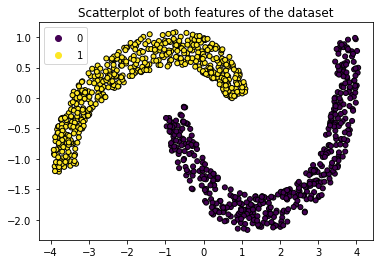

In [214]:
plt.title("Scatterplot of both features of the dataset")
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train, s=25, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()

No, the data is not linearly separable.


#### 2.  
Run the NN code (with one hidden layer and with two hidden layers) on the training datasetand evaluate on the test dataset.  Here, you need to explore the effect of different number ofneurons in the hidden layer(s).  Report classification error on the training set and on the testset, when using 10, 30 and 50 neurons in the hidden layer(s).  Plot the data (use differentcolors for data in different classes) and plot the classification results (points predicted to bein class+1with circles and points predicted to be in class −1 with squares).

#### Defining training  and testing the model

In [215]:
#Defining function to train and test the model


def classification_error(pred, y):
    correct = 0.0
    with torch.no_grad():
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        
    accuracy = correct/y.size(0)
    error = 1 - accuracy
    
    return accuracy, error
 

def do_train_epoch(model, x, y, criterion, optimizer):
    model.train()
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    
    optimizer.zero_grad()
    
    pred = model(x)
    y = y.reshape(-1).long()
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    
    accuracy, error = classification_error(pred.clone().detach(), y)
    
    return loss.item(), accuracy, error
    
    
def do_eval_epoch(model, x, y, criterion):
    model.eval()
    
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    
    pred = model(x)
    y = y.reshape(-1).long()
    loss = criterion(pred, y)
    accuracy, error = classification_error(pred.clone().detach(), y)
    
    return loss.item(), accuracy, error


def run_model(model, X_train, y_train, X_test, y_test):
    np.random.seed(0)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    losses, accs, errors = [], [], []
    epoch_no = 4000
    for epoch in range(epoch_no):
        tr_loss, tr_acc, tr_error = do_train_epoch(model, X_train, y_train, criterion, optimizer)
        te_loss, te_acc, te_error = do_eval_epoch(model, X_test, y_test, criterion)

        losses.append([tr_loss, te_loss])
        accs.append([tr_acc, te_acc])
        errors.append([tr_error, te_error])
        
    return losses, accs, errors
    

#### Running the model for different hidden layers and neurons

#### a) 1 hidden layer with 10 neurons

In [220]:
# Defining parameters and creating an object of the model
                                  
n_layers = 1
nodes = [10]
activation_list = ['relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
print(f"Train and test classification error respectively: {round(errors[-1][0] *100, 2)}%, {round(errors[-1][1]*100, 2)}%")
print(f"Weights of the output layer : {model.output_layer.weight}")
print(f"Weights of the output layer : {model.output_layer.bias}")

Train and test classification error respectively: 0.5%, 1.0%
Weights of the output layer : Parameter containing:
tensor([[ 9.0652e-01,  7.5053e-01, -7.3378e-02,  1.2972e+00, -1.4259e-03,
         -1.4708e+00, -1.8567e+00,  8.2485e-02,  2.3665e-01,  1.4761e+00],
        [-7.0789e-01, -1.0172e+00,  4.6700e-01, -1.2745e+00,  2.1504e-01,
          1.4315e+00,  1.9604e+00, -3.1033e-01, -1.4526e-02, -1.4193e+00]],
       requires_grad=True)
Weights of the output layer : Parameter containing:
tensor([-0.6121,  0.1058], requires_grad=True)


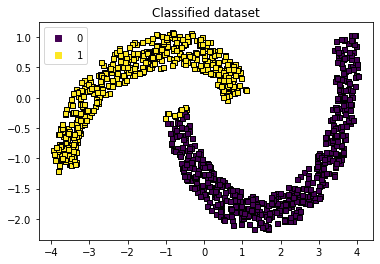

In [221]:
pred = model(X_test)
correct = 0
_, predicted1 = torch.max(pred, 1)

plt.title("Classified dataset")
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], marker='s', c=predicted1, s=25, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()

**Observation:** With 1 hidden layer and 10 neurons, we have 0.5% classification error on train data and 1% on test data.

#### b) 1 hidden layer with 30 neurons

In [226]:
n_layers = 1
nodes = [30]
activation_list = ['relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
print(f"Train and test classification error respectively: {round(errors[-1][0] *100, 2)}%, {round(errors[-1][1]*100, 2)}%")

Train and test classification error respectively: 0.4%, 0.8%


In [224]:
print(f"Weights of the output layer : {model.output_layer.weight}")
print(f"Weights of the output layer : {model.output_layer.bias}")

Weights of the output layer : Parameter containing:
tensor([[-0.4945,  0.4787, -0.3100, -0.2838,  0.6588,  0.0348, -0.5122, -0.8887,
         -0.6986, -0.8270, -0.1531, -0.8515,  1.1023,  0.8946, -0.0111,  0.1982,
          0.3442,  0.5372, -0.0362, -0.0112, -0.6430, -0.3371, -0.8159,  0.6508,
          0.6877,  1.0684, -0.7870, -0.1651, -0.3896, -0.7095],
        [ 0.4947, -0.5081,  0.3493,  0.5220, -0.7473, -0.2261,  0.6679,  0.5903,
          0.7559,  0.6653,  0.3970,  0.6627, -0.9756, -0.7062,  0.1950, -0.2080,
         -0.2774, -0.5597,  0.3123, -0.0062,  0.5230,  0.6022,  0.8778, -0.8090,
         -0.8700, -1.0611,  0.7488,  0.0624,  0.6451,  0.5187]],
       requires_grad=True)
Weights of the output layer : Parameter containing:
tensor([ 0.1128, -0.0345], requires_grad=True)


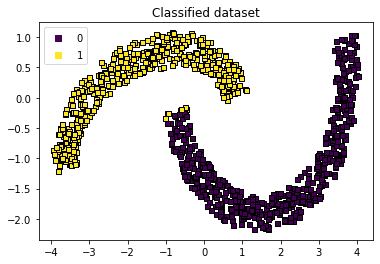

In [227]:
pred = model(X_test)
correct = 0
_, predicted2 = torch.max(pred, 1)

plt.title("Classified dataset")
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], marker='s', c=predicted2, s=25, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()

**Observation:** With 1 hidden layer and 30 neurons, we have 0.4% classification error for training data and 0.8% for test data which is better than the previous model.

#### c) 1 hidden layer with 50 neurons

In [229]:
n_layers = 1
nodes = [50]
activation_list = ['relu', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
print(f"Train and test classification error respectively: {round(errors[-1][0] *100, 2)}%, {round(errors[-1][1]*100, 2)}%")

Train and test classification error respectively: 0.0%, 0.0%


In [230]:
print(f"Weights of the output layer : {model.output_layer.weight}")
print(f"Weights of the output layer : {model.output_layer.bias}")

Weights of the output layer : Parameter containing:
tensor([[-8.5998e-01,  4.1481e-01,  1.8269e-01,  1.6283e-01, -2.5879e-01,
          5.3634e-01,  3.2214e-01, -3.2432e-01,  5.0016e-01, -2.7421e-01,
         -2.1743e-02,  7.9044e-01, -7.4867e-01, -7.6265e-01,  1.9769e-01,
         -5.3225e-01, -5.4674e-01,  3.3411e-01,  7.4108e-01,  2.2982e-01,
         -6.5668e-01, -1.9980e-01, -7.8419e-01,  1.2167e-02,  2.9818e-01,
         -5.7053e-01, -2.4460e-01,  7.0704e-02,  2.5323e-01,  5.0003e-01,
         -7.5071e-01,  2.8464e-01, -3.8554e-01, -5.4894e-02,  1.7282e-01,
         -1.6010e-02, -4.1928e-02,  3.3331e-01,  7.0086e-01, -5.6814e-01,
          4.0916e-01, -4.0704e-01,  8.1901e-01, -4.2738e-01, -1.0466e-01,
          5.7111e-02,  9.8959e-02,  3.1539e-01,  5.8486e-01,  6.8417e-01],
        [ 1.0861e+00, -3.3343e-01, -2.7521e-04, -1.5315e-01,  1.7399e-01,
         -6.7350e-01, -8.4902e-02,  3.4346e-01, -5.2942e-01,  6.3303e-02,
          1.7189e-01, -8.2311e-01,  6.5329e-01,  8.3022e-01

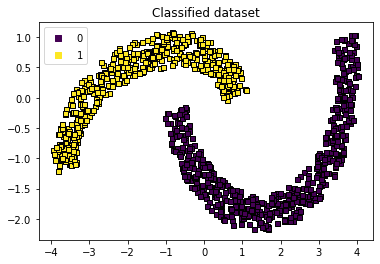

In [232]:
pred = model(X_test)
correct = 0
_, predicted3= torch.max(pred, 1)

plt.title("Classified dataset")
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], marker='s', c=predicted3, s=25, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()

**Observation:** With 1 hidden layer and 50 neurons, we have 0% train and test classification error and from the plot we see there is no misclassified point.

#### d) 2 hidden layers with 10 and 30 neurons

In [233]:
n_layers = 2
nodes = [10, 30]
activation_list = ['relu', 'tanh', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
print(f"Train and test classification error respectively: {round(errors[-1][0] *100, 2)}%, {round(errors[-1][1]*100, 2)}%")

Train and test classification error respectively: 0.0%, 0.0%


In [159]:
print(f"Weights of the output layer : {model.output_layer.weight}")
print(f"Weights of the output layer : {model.output_layer.bias}")

Weights of the output layer : Parameter containing:
tensor([[ 0.5809,  0.1105,  0.5037,  0.0514,  0.1980, -0.0820,  0.3966, -0.3373,
          0.8084,  0.0411, -0.6323, -0.3213,  0.0416,  0.1531, -0.7608, -0.3063,
          0.8924,  0.4298, -0.4605, -0.6740,  0.5459,  1.0134,  0.1440,  0.2721,
         -0.8087, -0.1668, -0.0030,  0.5442, -0.6960, -0.2740],
        [-0.5103, -0.4417, -0.4327, -0.0784, -0.1117, -0.1761, -0.5092,  0.4187,
         -0.5478, -0.2460,  0.3634,  0.4912, -0.1152, -0.2720,  0.6961,  0.4566,
         -0.6808, -0.5850,  0.3351,  0.7130, -0.6810, -1.0610, -0.3591, -0.3070,
          0.5939, -0.0924,  0.0772, -0.6512,  0.8275,  0.0776]],
       requires_grad=True)
Weights of the output layer : Parameter containing:
tensor([-0.1380,  0.2297], requires_grad=True)


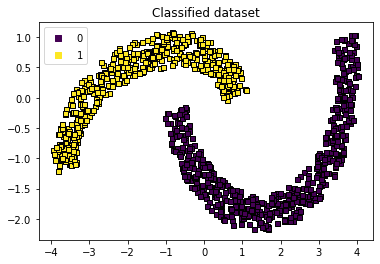

In [201]:
pred = model(X_test)
correct = 0
_, predicted4 = torch.max(pred, 1)

plt.title("Classified dataset")
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], marker='s', c=predicted4, s=25, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()

**Observation:** With 2 hidden layers of 10 and 30 neurons, we have no points misclassified and 0% classification error for training and test data, which shows that this model is also clearly able to classify the non linear data with 100% accuracy.

#### e) 2 hidden layers with 30 and 50 neurons

In [234]:
n_layers = 2
nodes = [30, 50]
activation_list = ['relu', 'tanh', 'sigmoid']
input_size = X_train.size(1)

model = Feedforward(input_size, n_layers, nodes, activation_list)

losses, accuracies, errors = run_model(model, X_train, y_train, X_test, y_test)
print(f"Train and test classification error respectively: {round(errors[-1][0] *100, 2)}%, {round(errors[-1][1]*100, 2)}%")

Train and test classification error respectively: 0.0%, 0.0%


In [235]:
print(f"Weights of the output layer : {model.output_layer.weight}")
print(f"Weights of the output layer : {model.output_layer.bias}")

Weights of the output layer : Parameter containing:
tensor([[-0.0144,  0.0941, -0.3665, -0.2092,  0.3401,  0.6666, -0.4786, -0.4196,
         -0.5680,  0.5853, -0.3388, -0.4121, -0.1533, -0.7102, -0.2334, -0.2697,
         -0.4094,  0.0191, -0.5137,  0.5073, -0.3777,  0.1952,  0.0560, -0.0703,
          0.4503, -0.0335,  0.4441, -0.0212, -0.1494,  0.4240,  0.3085,  0.0722,
         -0.0686, -0.0717, -0.3990,  0.7234,  0.4073, -0.0354, -0.1310, -0.2556,
         -0.1523, -0.3009, -0.4908,  0.5524,  0.1417,  0.1945,  0.3726, -0.4266,
         -0.1569, -0.2358],
        [ 0.0518, -0.2630,  0.2216,  0.4500, -0.2559, -0.6004,  0.5497,  0.2301,
          0.4565, -0.6090,  0.2428,  0.4839,  0.3216,  0.7702,  0.3754,  0.2069,
          0.3765,  0.0974,  0.3194, -0.4633,  0.3340, -0.2233, -0.0755,  0.2168,
         -0.7090, -0.0058, -0.2535, -0.0032,  0.1674, -0.3221, -0.3459, -0.2760,
          0.1298,  0.2309,  0.2830, -0.7374, -0.3825,  0.0212, -0.0034,  0.4142,
          0.0637,  0.2033,  0

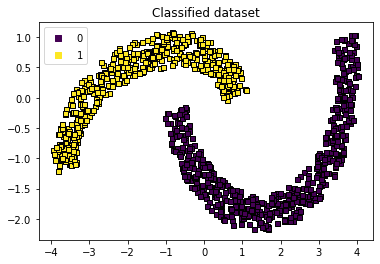

In [203]:
pred = model(X_test)
correct = 0
_, predicted5 = torch.max(pred, 1)

plt.title("Classified dataset")
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], marker='s', c=predicted5, s=25, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()

**Observation:** With 2 hidden layers of 30 and 50 neurons, we have no points misclassified for training and test data, which shows that this model is also clearly able to classify the non linear data with 100% accuracy.

#### Final Train Classification Plot

In [174]:
pred = model(X_train)
correct = 0
_, predicted = torch.max(pred, 1)
y = y_train.reshape(-1).long()
correct += (predicted == y).sum().item()
        
accuracy = correct/y.size(0)
accuracy  

1.0

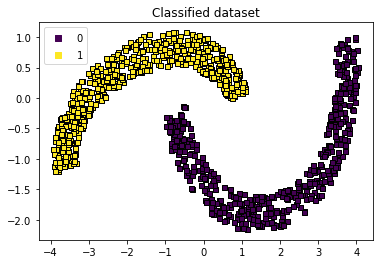

In [171]:
plt.title("Classified dataset")
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], marker='s', c=predicted, s=25, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()

#### Final Test Classification Plot

In [205]:
pred = model(X_test)
correct = 0
_, predicted_test = torch.max(pred, 1)

y_test = y_test.reshape(-1).long()
correct += (predicted_test == y_test).sum().item()
        
accuracy = correct/y_test.size(0)
accuracy 


1.0

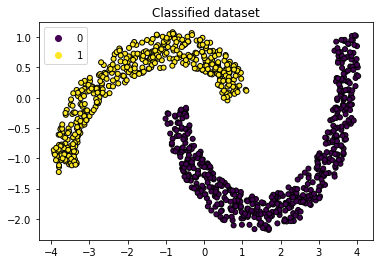

In [208]:
plt.title("Classified dataset")
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=predicted_test, s=25, edgecolor='k')
plt.legend(*scatter.legend_elements())
plt.show()

The above plots have been made from the model with 2 hidden layers with 30 and 50 neurons which gave 0 classification error for both train and test data. Hence, the classified plot is exactly same as the given dataset.